## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [135]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.metrics import mean_squared_error

%matplotlib inline

import xgboost as xgb

In [5]:
data_path = Path("Data/AB_NYC_2019.csv")
full_data_path = Path.cwd().parents[1].joinpath(data_path)
df = pd.read_csv(full_data_path)

In [8]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]
df = pd.read_csv(full_data_path, usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [11]:
df['price'] = np.log1p(df.price)

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.20, random_state=1)

In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [26]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [41]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

In [42]:
test_dicts = df_test.to_dict(orient='records')
X_test = dv.fit_transform(test_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [100]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [101]:
score = dt.score(X_val, y_val)
print(f"Score: {score}\nRMSE: {np.sqrt(score)}")

Score: 0.38680072900416795
RMSE: 0.6219330582982127


In [102]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



### Answer: room_type

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [103]:
dt_1 = RandomForestRegressor(n_estimators=10, random_state=1)
dt_1.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [105]:
score_1 = dt_1.score(X_val, y_val)
print(f"Score: {score_1}\nRMSE: {np.sqrt(score_1)}")

Score: 0.5696831330984111
RMSE: 0.7547735641226521


In [140]:
the_preds = dt_1.predict(X_val)
mse = mean_squared_error(y_val, the_preds)
rmse = np.sqrt(mse)
print(f"mean squared error: {rmse}")

mean squared error: 0.46078067210100937


In [81]:
#print(export_text(dt_1, feature_names=dv.get_feature_names()))

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

### Answer: 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [145]:
random_state = 1
for n in range(10, 200, 10):
    dt_n = RandomForestRegressor(n_estimators=n, random_state=random_state, n_jobs=-1)
    dt_n.fit(X_train, y_train)
    score_n = dt_n.score(X_val, y_val)
    
    y_preds = dt_n.predict(X_val)
    mse = mean_squared_error(y_val, y_preds)
    rmse = np.sqrt(mse)
    
    print(f"{n}\nScore:\t\t{score_n}\nSqrt score:\t{np.sqrt(score_n)}\nRMSE:\t\t{rmse}")

10
Score:		0.5696831330984111
Sqrt score:	0.7547735641226521
RMSE:		0.46078067210100937
20
Score:		0.5936348119914736
Sqrt score:	0.7704770028959161
RMSE:		0.4477734275103014
30
Score:		0.60138658014209
Sqrt score:	0.7754911863729271
RMSE:		0.44348203033518463
40
Score:		0.6037115011095424
Sqrt score:	0.776988739371133
RMSE:		0.4421868299723399
50
Score:		0.6050196730939559
Sqrt score:	0.7778301055461635
RMSE:		0.4414563841054784
60
Score:		0.6059672027700074
Sqrt score:	0.7784389525004561
RMSE:		0.4409265549453157
70
Score:		0.6073443428260729
Sqrt score:	0.7793230028852433
RMSE:		0.44015536393193144
80
Score:		0.6083625172577785
Sqrt score:	0.7799759722310543
RMSE:		0.43958432181362317
90
Score:		0.6087654298079224
Sqrt score:	0.78023421471243
RMSE:		0.43935814374764653
100
Score:		0.6091744640095509
Sqrt score:	0.7804962933989827
RMSE:		0.43912841008144876
110
Score:		0.6099199471096015
Sqrt score:	0.7809737172975807
RMSE:		0.4387094007857012
120
Score:		0.6103125361775483
Sqrt scor

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

### Answer: 70

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [147]:
random_state = 1
for d in [10, 15, 20, 25]:
    dt_n = RandomForestRegressor(n_estimators=10, max_depth=d, random_state=random_state)
    dt_n.fit(X_train, y_train)
    score_n = dt_n.score(X_val, y_val)
    
    y_preds = dt_n.predict(X_val)
    mse = mean_squared_error(y_val, y_preds)
    rmse = np.sqrt(mse)
    
    print(f"{d}\nScore:\t\t{score_n}\nSqrt score:\t{np.sqrt(score_n)}\nRMSE:\t\t{rmse}")

10
Score:		0.5968271359847189
Sqrt score:	0.7725458795338429
RMSE:		0.4460111502229752
15
Score:		0.5858870415877189
Sqrt score:	0.7654325846132491
RMSE:		0.4520219032808204
20
Score:		0.5741183271151935
Sqrt score:	0.7577059634945429
RMSE:		0.45839993242631316
25
Score:		0.5693713369234609
Sqrt score:	0.7545669863726221
RMSE:		0.46094757659246827


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

### Answer: 25

Yes, the seed changes how the randomness is so the values will change slightly

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [148]:
dt_2 = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
dt_2.fit(X_train, y_train)
score_2 = dt_2.score(X_val, y_val)

y_preds = dt_n.predict(X_val)
mse = mean_squared_error(y_val, y_preds)
rmse = np.sqrt(mse)

# print(f"\nScore:\t{score_2}\nRMSE:\t{np.sqrt(score_2)}\n")
print(f"\nScore:\t\t{score_2}\nSqrt score:\t{np.sqrt(score_2)}\nRMSE:\t\t{rmse}")


Score:		0.5741183271151935
Sqrt score:	0.7577059634945429
RMSE:		0.46094757659246827


In [149]:
df_train.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

<AxesSubplot:>

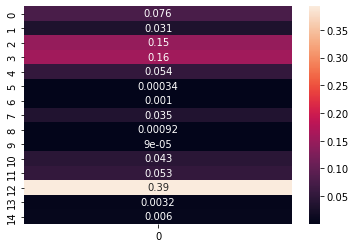

In [150]:
sns.heatmap(dt_2.feature_importances_.reshape(15,1), annot=True)

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

### Answer: longitude

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [124]:
feats = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feats)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feats)

Now change `eta` first to `0.1` and then to `0.01`

In [131]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
dst = xgb.train(xgb_params, dtrain, num_boost_round=100)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

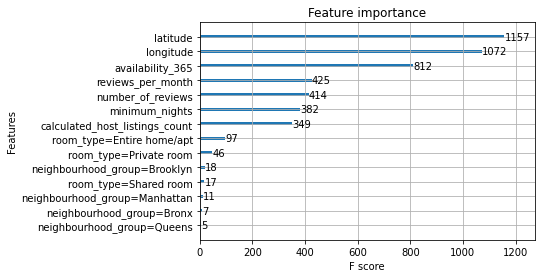

In [132]:
xgb.plot_importance(dst)

In [151]:
y_pred = dst.predict(dval)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
rmse

0.43723814828957047

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

In [ ]:
### Answer 

In [152]:
for eta in [.3, .1, .01]:
    xgb_params["eta"] = eta
    dst = xgb.train(xgb_params, dtrain, num_boost_round=100)
    y_pred = dst.predict(dval)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print(f"ETA: {eta}\nRMSE: {rmse}\n")

ETA: 0.3
RMSE: 0.43723814828957047

ETA: 0.1
RMSE: 0.4345855408382242

ETA: 0.01
RMSE: 1.631293499371654



## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

